### Pipeline 1 (biclase): PCA → MLP (baseline)


- Split temporal (train = 70%, val = 15%, test = 15% por orden cronológico).
- StandardScaler + PCA 
- Entrenamiento con `WeightedRandomSampler` 
- Métricas: F1 macro, Balanced Accuracy, MCC, PR-AUC (Attack), reporte, matriz de confusión, curva PR.

> Ajusta la ruta al parquet si hace falta.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet("../Limpieza_Completada/cicids2017_CleanBinary.parquet")
ts_df = pd.read_parquet("../Timestamp_Datetime_Terminado/Timestamp_Tipo_Datetime.parquet")

#Unión
df["Timestamp"] = ts_df["Timestamp"].values
#Ordenar
df = df.sort_values("Timestamp").reset_index(drop=True)


### Definir X e y (biclase)
- y sale de Attack.
- X son columnas numéricas.


In [2]:
y = df["Attack"].astype(np.int64).values

X_df = df.select_dtypes(include=[np.number]).copy()

### Split temporal (train/val/test)
70% / 15% / 15% en orden cronológico

In [3]:
n = len(df)
i_train = int(n * 0.70)
i_val   = int(n * 0.85)

X_train_df = X_df.iloc[:i_train]
X_val_df   = X_df.iloc[i_train:i_val]
X_test_df  = X_df.iloc[i_val:]

y_train = y[:i_train]
y_val   = y[i_train:i_val]
y_test  = y[i_val:]

print(X_train_df.shape, X_val_df.shape, X_test_df.shape)
print("Train:", np.bincount(y_train, minlength=2))
print("Val:", np.bincount(y_val, minlength=2))
print("Test:", np.bincount(y_test, minlength=2))

(1981377, 72) (424581, 72) (424581, 72)
Train: [1714580  266797]
Val: [264157 160424]
Test: [294157 130424]


### Escalado + PCA (fit solo en train)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_df)
X_val_s   = scaler.transform(X_val_df)
X_test_s  = scaler.transform(X_test_df)

pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_s)
X_val   = pca.transform(X_val_s)
X_test  = pca.transform(X_test_s)

print("PCA components:", X_train.shape[1])
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


PCA components: 26
Shapes: (1981377, 26) (424581, 26) (424581, 26)


### Dataset + DataLoaders (con WeightedRandomSampler en TRAIN)


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
val_ds   = TabularDataset(X_val, y_val)
test_ds  = TabularDataset(X_test, y_test)

class_counts = np.bincount(y_train, minlength=2)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 2048  
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("class_counts:", class_counts)
print("batches:", len(train_loader), len(val_loader), len(test_loader))

class_counts: [1714580  266797]
batches: 967 208 208


### MLP
Usamos `CrossEntropyLoss` simple porque ya balanceamos con sampler.

In [6]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cpu")

input_dim = X_train.shape[1]
n_classes = 2

class MLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Entrenamiento + selección por métrica en VALIDACIÓN


In [7]:
from sklearn.metrics import f1_score, average_precision_score

def predict_proba(model, loader):
    model.eval()
    y_true, y_pred, y_proba = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            y_true.append(yb.numpy())
            y_pred.append(np.argmax(probs, axis=1))
            y_proba.append(probs)
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_proba)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(len(loader), 1)

def eval_metrics(model, loader):
    y_true, y_pred, y_proba = predict_proba(model, loader)
    f1m = f1_score(y_true, y_pred, average="macro")
    pr_auc_attack = average_precision_score(y_true, y_proba[:, 1])
    return f1m, pr_auc_attack

EPOCHS = 10
best_score = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(model, train_loader)
    f1m_val, pr_val = eval_metrics(model, val_loader)
    print(f"Epoch {epoch}/{EPOCHS} | loss={loss:.4f} | F1_macro(val)={f1m_val:.4f} | PR-AUC_Attack(val)={pr_val:.4f}")

    score = pr_val 
    if score > best_score:
        best_score = score
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

print("Best PR-AUC_Attack(val):", best_score)

model.load_state_dict(best_state)
model.to(device)

Epoch 1/10 | loss=0.0203 | F1_macro(val)=0.9027 | PR-AUC_Attack(val)=0.9863
Epoch 2/10 | loss=0.0008 | F1_macro(val)=0.8763 | PR-AUC_Attack(val)=0.9772
Epoch 3/10 | loss=0.0004 | F1_macro(val)=0.8742 | PR-AUC_Attack(val)=0.9748
Epoch 4/10 | loss=0.0003 | F1_macro(val)=0.8999 | PR-AUC_Attack(val)=0.9782
Epoch 5/10 | loss=0.0002 | F1_macro(val)=0.8691 | PR-AUC_Attack(val)=0.9757
Epoch 6/10 | loss=0.0002 | F1_macro(val)=0.8554 | PR-AUC_Attack(val)=0.9721
Epoch 7/10 | loss=0.0001 | F1_macro(val)=0.8657 | PR-AUC_Attack(val)=0.9735
Epoch 8/10 | loss=0.0002 | F1_macro(val)=0.8535 | PR-AUC_Attack(val)=0.9715
Epoch 9/10 | loss=0.0001 | F1_macro(val)=0.8561 | PR-AUC_Attack(val)=0.9693
Epoch 10/10 | loss=0.0004 | F1_macro(val)=0.8495 | PR-AUC_Attack(val)=0.9683
Best PR-AUC_Attack(val): 0.9862665165422594


MLP(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

### Evaluación en TEST
F1, MCC, PR-AUC (Attack), Balanced Accuracy y matriz de confusión.

In [8]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, classification_report, confusion_matrix

y_true, y_pred, y_proba = predict_proba(model, test_loader)

f1_macro = f1_score(y_true, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(y_true, y_pred)
mcc      = matthews_corrcoef(y_true, y_pred)
pr_auc_attack = average_precision_score(y_true, y_proba[:, 1])

print("TEST metrics")
print("F1 macro:", f1_macro)
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("PR-AUC (Attack):", pr_auc_attack)

print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

TEST metrics
F1 macro: 0.9961798867117
Balanced Accuracy: 0.9948405607578924
MCC: 0.9923842972816148
PR-AUC (Attack): 0.9973999322570836

Classification report:
               precision    recall  f1-score   support

           0     0.9955    0.9998    0.9977    294157
           1     0.9996    0.9899    0.9947    130424

    accuracy                         0.9968    424581
   macro avg     0.9975    0.9948    0.9962    424581
weighted avg     0.9968    0.9968    0.9968    424581

Confusion matrix:
 [[294101     56]
 [  1321 129103]]


### Curva Precision-Recall en TEST

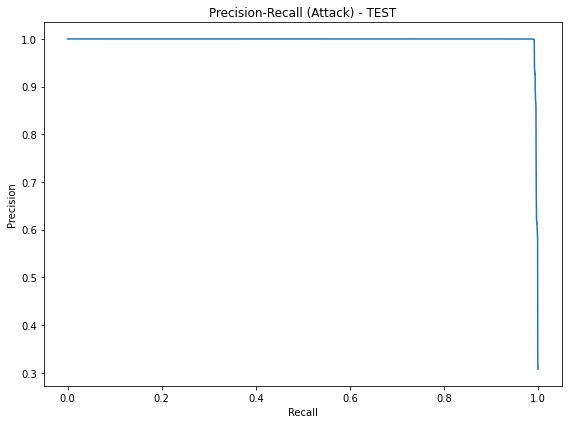

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_true, y_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(rec, prec)
plt.title("Precision-Recall (Attack) - TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

In [14]:
import os, json
import numpy as np
import pandas as pd

os.makedirs("exports", exist_ok=True)

# Timestamp TEST (a nivel de fila/flujo)
ts_test = df["Timestamp"].iloc[i_val:].reset_index(drop=True)

# Probabilidad de Attack (clase 1)
p_attack = y_proba[:, 1].astype(float)

out = pd.DataFrame({
    "pipeline": "p1_pca_mlp",
    "timestamp": ts_test,
    "y_true": y_true.astype(int),
    "y_pred": y_pred.astype(int),
    "p_attack": p_attack,
})

out.to_parquet("exports/p1_test_preds.parquet", index=False)
print("Guardado:", "exports/p1_test_preds.parquet", "| shape:", out.shape)

meta = {
    "pipeline": "p1_pca_mlp",
    "task": "binary",
    "split": "temporal",
    "train_frac": 0.70,
    "val_frac": 0.15,
    "test_frac": 0.15,
    "pca_components": int(X_train.shape[1]),
}
with open("exports/p1_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, default=str)
print("Guardado:", "exports/p1_meta.json")


Guardado: exports/p1_test_preds.parquet | shape: (424581, 5)
Guardado: exports/p1_meta.json


### PERMUTATION IMPORTANCE
¿Qué variables (o componentes PCA) son más importantes para el modelo entrenado?

In [10]:
from sklearn.metrics import average_precision_score
import pandas as pd
import numpy as np

def permutation_importance_pca(
    model, X_test, y_true, metric_fn, n_repeats=1, batch_size=2048
):
    baseline_proba = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            xb = torch.tensor(X_test[i:i+batch_size], dtype=torch.float32)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            baseline_proba.append(probs)
    baseline_proba = np.concatenate(baseline_proba)
    baseline_score = metric_fn(y_true, baseline_proba)

    importances = []

    for j in range(X_test.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_perm = X_test.copy()
            np.random.shuffle(X_perm[:, j])

            perm_proba = []
            with torch.no_grad():
                for i in range(0, len(X_perm), batch_size):
                    xb = torch.tensor(X_perm[i:i+batch_size], dtype=torch.float32)
                    logits = model(xb)
                    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
                    perm_proba.append(probs)
            perm_proba = np.concatenate(perm_proba)
            score = metric_fn(y_true, perm_proba)
            scores.append(baseline_score - score)

        importances.append(np.mean(scores))

    return np.array(importances), baseline_score


# === Ejecutar permutation importance ===
pi_scores, base_pr_auc = permutation_importance_pca(
    model=model,
    X_test=X_test,
    y_true=y_true,
    metric_fn=average_precision_score,
    n_repeats=1
)

pi_df = pd.DataFrame({
    "feature": [f"PC{i}" for i in range(len(pi_scores))],
    "importance_pr_auc_drop": pi_scores
}).sort_values("importance_pr_auc_drop", ascending=False)

print("Baseline PR-AUC:", base_pr_auc)
pi_df.head(20)


Baseline PR-AUC: 0.9973999322570836


,feature,importance_pr_auc_drop
0,PC0,0.372583
4,PC4,0.133340
18,PC18,0.032753
24,PC24,0.030644
23,PC23,0.021775
25,PC25,0.013557
5,PC5,0.011123
22,PC22,0.010104
7,PC7,0.008442
14,PC14,0.007684
